In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
import logging
import numpy as np
import h5py
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import jax
import jax.numpy as jnp
from flax import nnx
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from heavyhex_qft.triangular_z2 import TriangularZ2Lattice
from heavyhex_qft.plaquette_dual import PlaquetteDual
from skqd_z2lgt.circuits import make_step_circuits, compose_trotter_circuits
from skqd_z2lgt.mwpm import convert_link_to_plaq
from skqd_z2lgt.crbm import ConditionalRBM
from skqd_z2lgt.train_crbm import DefaultCallback, NLLCallback, cd_percloss, cd_meanloss, nll_loss, train_crbm, make_l2_loss_fn

os.environ['CUDA_VISIBLE_DEVICES'] = '7'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'
jax.config.update('jax_enable_x64', True)

logging.basicConfig(level=logging.WARNING)
logging.getLogger('skqd_z2lgt').setLevel(logging.INFO)
LOG = logging.getLogger()
LOG.setLevel(logging.INFO)

In [2]:
logging.getLogger('jax').setLevel(logging.WARNING)

In [3]:
output_file = h5py.File('/data/iiyama/2dz2/recovery_learning.h5', 'r+')

In [4]:
lattice = TriangularZ2Lattice('''
 * * *
* * * *
 * * *
''')
plaquette_energy = 0.8
delta_t = 0.5
num_steps = 5
basis_2q = 'cz'

dual_lattice = PlaquetteDual(lattice)
ising_hamiltonian = dual_lattice.make_hamiltonian(plaquette_energy)

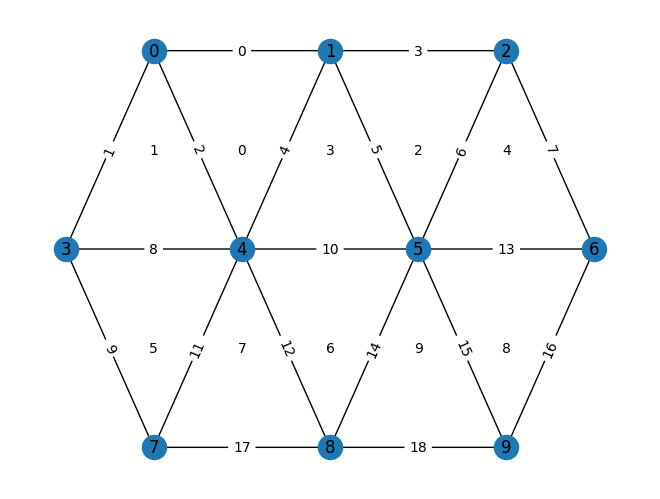

In [5]:
lattice.draw_graph();

## Compose the circuits and run the experiments

In [6]:
def run_experiments(lattice, backend):
    layout = lattice.layout_heavy_hex(backend.coupling_map, backend_properties=backend.properties(), basis_2q=basis_2q)
    full_step, fwd_step, bkd_step, measure = transpile(
        make_step_circuits(lattice, plaquette_energy, delta_t, basis_2q),
        backend=backend, initial_layout=layout, optimization_level=2
    )
    id_step = fwd_step.compose(bkd_step)
    exp_circuits = compose_trotter_circuits(full_step, measure, num_steps)
    ref_circuits = compose_trotter_circuits(id_step, measure, num_steps)

    sampler = Sampler(backend)
    job = sampler.run(exp_circuits + ref_circuits, shots=backend.configuration().max_shots)
    return job

## Convert link-state counts to plaquette-state arrays with MWPM

In [7]:
try:
    data = output_file['data'][()]
except KeyError:
    compute = True
else:
    compute = False

if compute:
    try:
        del output_file['data']
    except KeyError:
        pass

    service = QiskitRuntimeService(instance='ICEPP-dedicated-temp-prem-us')

    try:
        job_id = output_file['job_id'][()].decode()
    except KeyError:
        backend = service.backend('ibm_pittsburgh')
        job = run_experiments(lattice, backend)
        output_file.create_dataset('job_id', data=job.job_id())
    else:
        job = service.job(job_id)

    result = job.result()

    with ProcessPoolExecutor() as executor:
        futures = []
        for res in result[5:]:
            futures.append(executor.submit(convert_link_to_plaq, res.data.c.get_counts(), dual_lattice))
        step_plaq_data = [future.result() for future in futures]

    data = np.array(step_plaq_data)
    output_file.create_dataset('data', data=data)

In [8]:
num_vertices = lattice.num_vertices
num_plaquettes = lattice.num_plaquettes

In [9]:
class LiveViewMixin:
    def __init__(self, u_states, v_data, eval_every: int = 100, **metrics):
        super().__init__(eval_every=eval_every, **metrics)
        self.u_states = u_states
        self.v_data = v_data
        self.losses = []
        self.fig_loss = plt.subplots()[0]
        self.fig_act_mean = plt.subplots(5, 4, sharex=True, sharey=True)[0]
        self.fig_act_count = plt.subplots(5, 4, sharex=True, sharey=True)[0]

    def _test_ext(
        self,
        model: ConditionalRBM,
        test_u: jax.Array,
        test_v: jax.Array,
        loss: jax.Array,
        iepoch: int
    ):
        clear_output()
        self.losses.append(float(loss))
        self.fig_loss.axes[0].clear()
        self.fig_loss.axes[0].plot(self.losses)
        display(self.fig_loss)

        for u_state, v_data, ax_mean, ax_count in \
                zip(self.u_states, self.v_data, self.fig_act_mean.axes, self.fig_act_count.axes):
            v_gen = model.sample(u_state, size=10000)
            x = np.arange(v_gen.shape[1])
            ax_mean.clear()
            ax_mean.bar(x, np.mean(v_gen, axis=0), width=0.9, label='gen')
            ax_mean.bar(x, np.mean(v_data, axis=0), width=0.9, fill=False, label='data')

            counts, bins = np.histogram(np.sum(v_gen, axis=1), np.linspace(-0.5, 10.5, 12))
            ax_count.clear()
            ax_count.stairs(counts / v_gen.shape[0] * v_data.shape[0], bins, fill=True)
            ax_count.hist(np.sum(v_data, axis=1), bins, fill=False)

        display(self.fig_act_mean)
        display(self.fig_act_count)


class LiveViewDefaultCallback(LiveViewMixin, DefaultCallback):
    pass

class LiveViewNLLCallback(LiveViewMixin, NLLCallback):
    pass

In [10]:
istep = 0

num_h = 256
num_epochs = 10
batch_size = 32
loss = 'cdm'
lr = 0.001
l2w_weights = 1.
l2w_biases = 0.2

model_filename = f'/data/iiyama/2dz2/crbm_models/p10_i{istep}_h{num_h}_b{batch_size}_lr{lr:.0e}_e{num_epochs}_{loss}_l2w{l2w_weights:.0e}_l2b{l2w_biases}.h5'

train_dataset = data[istep][:80_000]
test_dataset = data[istep][80_000:]

u_states, inverse, u_counts = np.unique(test_dataset[:, :num_vertices], return_counts=True,
                                        return_inverse=True, axis=0)
u_states = u_states[u_counts > 100]
u_indices = np.nonzero(u_counts > 100)[0]
v_data = []
for uid in u_indices:
    mask = inverse == uid
    v_data.append(test_dataset[mask, num_vertices:])

compute = not os.path.exists(model_filename)
compute = True

if compute:
    mean_activation = np.mean(train_dataset[:, num_vertices:], axis=0)
    mean_activation = np.where(np.isclose(mean_activation, 0.), 1.e-6, mean_activation)
    bias_init = np.log(mean_activation / (1. - mean_activation))
    h_sparsity = 0.01

    rngs = nnx.Rngs(params=0, sample=1)
    model = ConditionalRBM(num_vertices, num_plaquettes, num_h, rngs=rngs)
    model.bias_v.value = bias_init
    model.bias_h.value = jnp.full(model.bias_h.shape, np.log(h_sparsity / (1. - h_sparsity)))

else:
    model = ConditionalRBM.load(model_filename)
    with h5py.File(model_filename.replace('.h5', '_records.h5'), 'r') as source:
        group = source['records']
        records = {key: array[()] for key, array in group.items()}

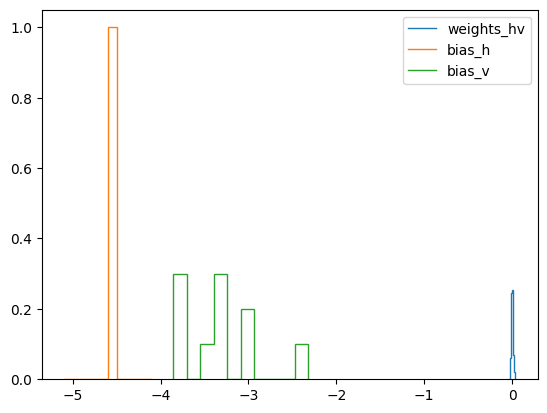

In [11]:
counts, bins = np.histogram(np.array(model.weights_hv.value).reshape(-1))
plt.stairs(counts / np.prod(model.weights_hv.shape), bins, label='weights_hv')
counts, bins = np.histogram(np.array(model.bias_h.value).reshape(-1))
plt.stairs(counts / np.prod(model.bias_h.shape), bins, label='bias_h')
counts, bins = np.histogram(np.array(model.bias_v.value).reshape(-1))
plt.stairs(counts / np.prod(model.bias_v.shape), bins, label='bias_v')
plt.legend();

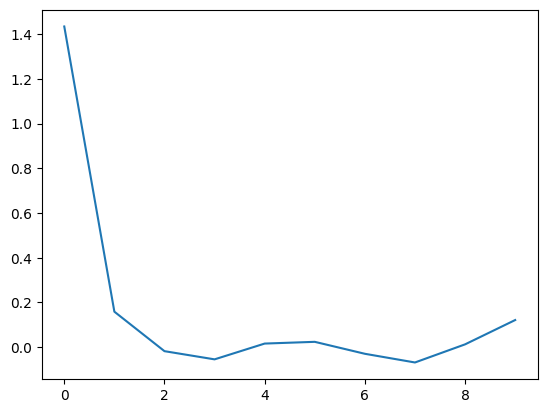

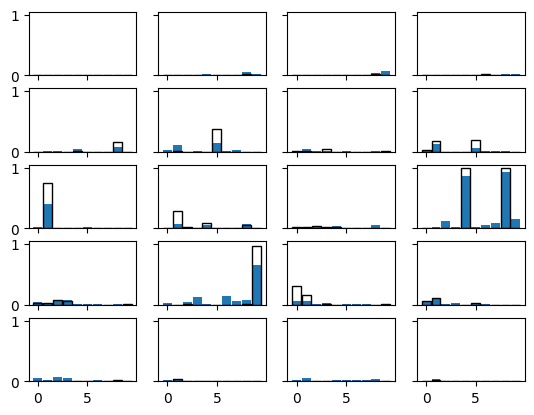

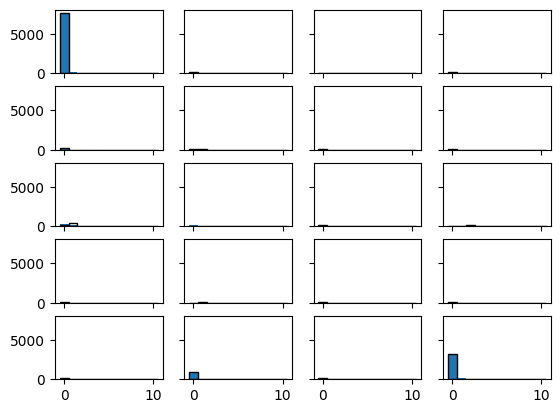

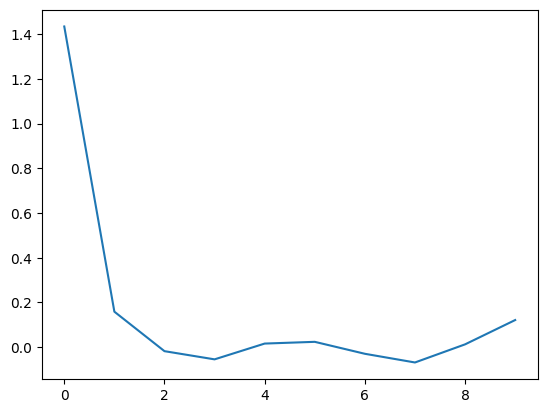

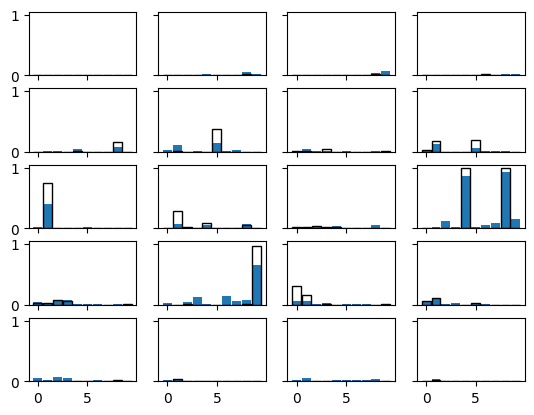

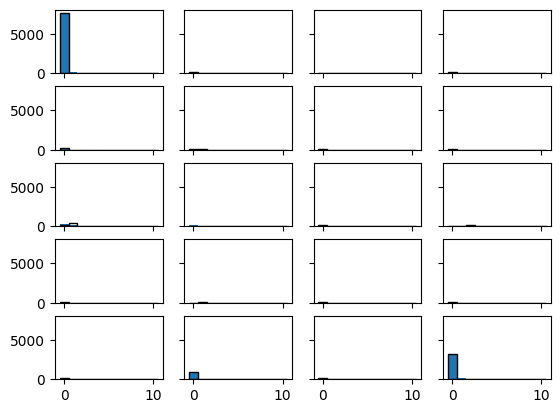

In [12]:
if compute:
    if loss == 'cd':
        # loss_fn = cd_percloss(l2_weight=1.)
        loss_fn = ('cd', l2w_weights, l2w_biases)
        callback = LiveViewDefaultCallback(u_states, v_data, eval_every=100)
    elif loss == 'cdm':
        loss_fn = cd_meanloss
        callback = LiveViewDefaultCallback(u_states, v_data, eval_every=100)
    elif loss == 'nll':
        loss_fn = nll_loss
        callback = LiveViewNLLCallback(u_states, v_data, eval_every=100)

    if loss != 'cd':
        loss_fn = make_l2_loss_fn(loss_fn, l2w_weights, l2w_biases)

    records = train_crbm(model, train_dataset, test_dataset, batch_size, num_epochs, loss_fn, lr,
                         callback=callback)
    model.save(model_filename)
    with h5py.File(model_filename.replace('.h5', '_records.h5'), 'w') as out:
        group = out.create_group('records')
        for key, array in records.items():
            group.create_dataset(key, data=array)

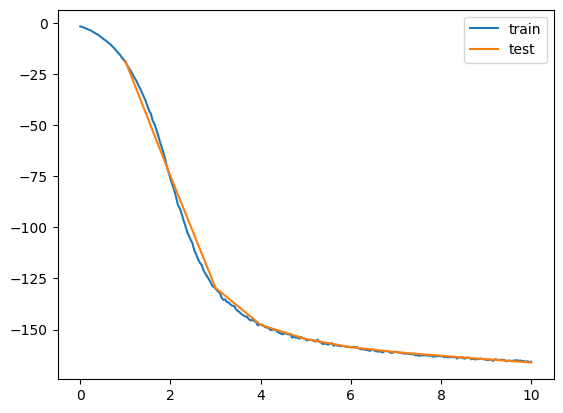

In [13]:
evals_per_epoch = 80000 // batch_size // 100
x_train = np.linspace(0., num_epochs, evals_per_epoch * num_epochs)
x_test = np.arange(0, num_epochs) + 1
plt.plot(x_train, records['train_free_energy'], label='train')
plt.plot(x_test, records['test_free_energy'], label='test')
plt.legend();

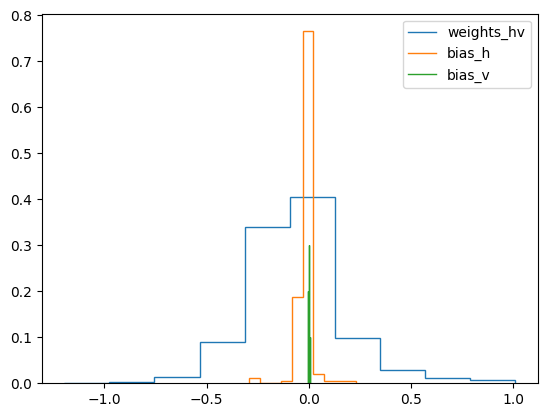

In [14]:
counts, bins = np.histogram(np.array(model.weights_hv.value).reshape(-1))
plt.stairs(counts / np.prod(model.weights_hv.shape), bins, label='weights_hv')
counts, bins = np.histogram(np.array(model.bias_h.value).reshape(-1))
plt.stairs(counts / np.prod(model.bias_h.shape), bins, label='bias_h')
counts, bins = np.histogram(np.array(model.bias_v.value).reshape(-1))
plt.stairs(counts / np.prod(model.bias_v.shape), bins, label='bias_v')
plt.legend();